In [1]:
from utils import evaluate_policy, str2bool, test_policy, all_seed, Actor, Critic
from datetime import datetime
import gymnasium as gym
import os, shutil
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from collections import deque

In [2]:
def get_args():
    # 创建命令行参数解析器
    parser = argparse.ArgumentParser()

    # 添加各种命令行参数
    parser.add_argument('--algo_name', default='AC', type=str, help="算法名")
    parser.add_argument('--dvc', type=str, default='cuda', help='运行设备: cuda 或 cpu')
    parser.add_argument('--env_name', type=str, default='CartPole-v1', help='环境名')
    parser.add_argument('--render_mode', type=str, default='rgb_array', help='环境渲染模式')
    parser.add_argument('--write', type=str2bool, default=True, help='使用SummaryWriter记录训练')
    parser.add_argument('--render', type=str2bool, default=False, help='是否渲染')
    parser.add_argument('--Loadmodel', type=str2bool, default=False, help='是否加载预训练模型')
    parser.add_argument('--ModelIdex', type=int, default=100000, help='要加载的模型索引')
    parser.add_argument('--deque_maxlen',default=40,type=int)

    parser.add_argument('--seed', type=int, default=10, help='随机种子')
    parser.add_argument('--Max_train_steps', type=int, default=5e7, help='最大训练步数')
    parser.add_argument('--save_interval', type=int, default=2e3, help='模型保存间隔，以步为单位')
    parser.add_argument('--eval_interval', type=int, default=1e3, help='模型评估间隔，以步为单位')
    parser.add_argument('--test_interval', type=int, default=2e3, help='视频保存间隔，以步为单位')

    parser.add_argument('--gamma', type=float, default=0.98, help='折扣因子')
    parser.add_argument('--K_epochs', type=int, default=1, help='网络更新次数')
    parser.add_argument('--net_width', type=int, default=128, help='隐藏网络宽度')
    parser.add_argument('--a_lr', type=float, default=1e-3, help='学习率')
    parser.add_argument('--c_lr', type=float, default=1e-2, help='学习率')
    
    # 解析命令行参数
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    
    return args

In [3]:
def print_args(args):
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))  

In [4]:
class AC:
    def __init__(self, kwargs):
        self.__dict__.update(kwargs)
        self.actor_net = Actor(self.state_dim, self.net_width, self.action_dim).to(self.dvc)
        self.actor_optimizer = torch.optim.Adam(self.actor_net.parameters(), lr=self.a_lr)  # 使用Adam优化器
        self.critic_net = Critic(self.state_dim, self.net_width).to(self.dvc)
        self.critic_optimizer = torch.optim.Adam(self.critic_net.parameters(), lr=self.c_lr)  # 使用Adam优化器

    def choose_action(self, state):  # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.dvc)
        probs = self.actor_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.dvc)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.dvc)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.dvc)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.dvc)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.dvc)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic_net(next_states) * (1 - dones)
        # 时序差分误差
        td_delta = td_target - self.critic_net(states)
        log_probs = torch.log(self.actor_net(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic_net(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数
    
        return actor_loss, critic_loss

    def save(self, episode):
        """
        保存当前训练模型的Actor和Critic参数到文件

        参数:
        - episode: 当前训练的episode数，用于在文件名中标识不同的保存点
        """
        model_path = f"model/{cfg['path']}"
        # 检查是否存在'model'文件夹，如果不存在则创建
        try:
            os.makedirs(model_path)
        except FileExistsError:
            pass
        # 保存Critic的参数到文件
        torch.save(self.critic_net.state_dict(), f"{model_path}/ac_critic{episode}.pth")
        # 保存Actor的参数到文件
        torch.save(self.actor_net.state_dict(), f"{model_path}/ac_actor{episode}.pth")

    def load(self, episode):
        """
        从文件加载之前保存的Actor和Critic参数

        参数:
        - episode: 要加载的保存点的episode数
        """
        # 加载之前保存的Critic的参数
        self.critic_net.load_state_dict(torch.load("./model/ac_critic{}.pth".format(episode)))
        # 加载之前保存的Actor的参数
        self.actor_net.load_state_dict(torch.load("./model/ac_actor{}.pth".format(episode)))

In [5]:
def env_agent_config(cfg, path):
    """
    配置环境和代理

    参数:
    - cfg: 包含配置信息的字典
    - path: 模型保存路径

    返回:
    - env: Gym 环境
    - agent: PPO 代理

    说明:
    1. 创建指定环境并设置渲染模式。
    2. 如果配置中设置了种子，则为环境设置种子。
    3. 获取环境的状态空间维度和动作空间维度。
    4. 更新配置字典中的状态维度和动作维度。
    5. 创建 PPO 代理。

    注意:
    - PPO 代理的创建依赖于配置信息和模型保存路径。
    """
    env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])  # 1. 创建环境
    eval_env = gym.make(cfg['env_name'], render_mode=cfg['render_mode'])
    if cfg['seed'] != 0:
        all_seed(env, seed=cfg['seed'])  # 2. 如果配置中设置了种子，则为环境设置种子

    n_states = env.observation_space.shape[0]  # 3. 获取状态空间维度
    n_actions = env.action_space.n  # 获取动作空间维度
    max_e_steps = env._max_episode_steps  # 最大步数
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}，最大步数：{max_e_steps}")
    cfg.update({"state_dim": n_states, "action_dim": n_actions, "max_e_steps": max_e_steps})  # 4. 更新n_states和n_actions到cfg参数中

    agent = AC(cfg)  # 5. 创建 PPO 代理
    return env, eval_env, agent

In [6]:
# 获取参数
cfg = get_args()

path = f"device:{cfg['dvc']}/{cfg['env_name']}/seed:{cfg['seed']}/{cfg['algo_name']}/net_width-{cfg['net_width']}-gamma-{cfg['gamma']}-K_epochs-{cfg['K_epochs']}-a_lr-{cfg['a_lr']}-c_lr-{cfg['c_lr']}"
cfg.update({"path":path}) # 更新n_states和n_actions到cfg参数中

base_dir = f"log/{cfg['path']}"

env, eval_env, agent = env_agent_config(cfg, path)

cfg.update({"mean_break":cfg['max_e_steps'] * 0.99})

print_args(cfg)

状态空间维度：4，动作空间维度：2，最大步数：500
超参数
        Name        	       Value        	        Type        
     algo_name      	         AC         	   <class 'str'>    
        dvc         	        cuda        	   <class 'str'>    
      env_name      	    CartPole-v1     	   <class 'str'>    
    render_mode     	     rgb_array      	   <class 'str'>    
       write        	         1          	   <class 'bool'>   
       render       	         0          	   <class 'bool'>   
     Loadmodel      	         0          	   <class 'bool'>   
     ModelIdex      	       100000       	   <class 'int'>    
    deque_maxlen    	         40         	   <class 'int'>    
        seed        	         10         	   <class 'int'>    
  Max_train_steps   	     50000000.0     	  <class 'float'>   
   save_interval    	       2000.0       	  <class 'float'>   
   eval_interval    	       1000.0       	  <class 'float'>   
   test_interval    	       2000.0       	  <class 'float'>   
       gamma        	   

In [7]:
def train(cfg):
    print("开始训练")
    env_seed = cfg['seed']
    # 使用TensorBoard记录训练曲线
    if cfg['write']:
        writepath = 'runs/{}'.format(cfg['path']) # 构建TensorBoard日志路径
        if os.path.exists(writepath): shutil.rmtree(writepath)  # 如果路径已存在，则删除该路径及其内容
        writer = SummaryWriter(log_dir=writepath)  # 创建TensorBoard写入器，指定日志路径

    # 如果指定了加载模型的选项，则加载模型
    if cfg['Loadmodel']:
        print("加载模型")
        agent.load(cfg['ModelIdex'])

    # 如果选择渲染模式
    if cfg['render']:
        while True:
            # 在环境中评估智能体的性能，并输出奖励
            ep_r = evaluate_policy(env, agent, turns=1)
            print('Env: ', cfg['env_name'],' Episode Reward: ', {ep_r})
    else:
        total_steps = 0  # 记录训练步数
        test_steps = 0  # 记录测试步数
        scores_deque = deque(maxlen=cfg['deque_maxlen'])

        # 在达到最大训练步数前一直进行训练
        while total_steps < cfg['Max_train_steps']:
            episode_return = 0  # 记录每个episode的奖励
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
                }
            
            s, info = env.reset(seed=env_seed)  # 重置环境，使用环境种子
            env_seed += 1
            done = False

            # 与环境进行交互并训练
            while not done:
                # 选择动作和动作对应的对数概率
                a = agent.choose_action(s)  # 在训练时使用随机动作
                s_next, r, dw, tr, info = env.step(a)  # 执行动作并获取下一个状态、奖励以及其他信息
                done = (dw or tr)  # 如果游戏结束（死亡或胜利），则done为True

                # 存储当前的转移数据
                transition_dict['states'].append(s)
                transition_dict['actions'].append(a)
                transition_dict['next_states'].append(s_next)
                transition_dict['rewards'].append(r)
                transition_dict['dones'].append(done)
                s = s_next
                episode_return += r  # 累计奖励
                
            total_steps += 1
            
            scores_deque.append(episode_return)

            # 更新智能体的策略
            for _ in range(cfg['K_epochs']):
                actor_loss, critic_loss = agent.update(transition_dict)  # 执行PPO算法的训练步骤
            if cfg['write']:
                writer.add_scalar('Actor_Loss', actor_loss, global_step=total_steps)
                writer.add_scalar('Critic_Loss', critic_loss, global_step=total_steps)
                writer.add_scalar('Episode_Reward', episode_return, global_step=total_steps)
                writer.add_scalar('Episode_Average_Reward', np.mean(scores_deque), global_step=total_steps)

            # 如果达到记录和日志的时间
            if total_steps % cfg['eval_interval'] == 0:
                # 在评估环境中评估智能体，并输出平均奖励
                score = evaluate_policy(eval_env, agent, total_steps, turns=3)  # 对策略进行3次评估，取平均值
                scores_deque.append(score)
                test_steps += 1
                if cfg['write']:
                    writer.add_scalar('Score_ep', score, global_step=total_steps)  # 将评估得分记录到TensorBoard
                    writer.add_scalar('Score_Average', np.mean(scores_deque), global_step=total_steps)
                print('EnvName:', cfg['env_name'], 'seed:', cfg['seed'],
                        'steps: {}k'.format(int(total_steps / 1000)), 'score:', score)
                    
            if total_steps % cfg['test_interval'] == 0:
                test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)

            # 如果达到保存模型的时间
            if total_steps % cfg['save_interval'] == 0:
                print("保存模型")
                agent.save(total_steps)  # 保存模型

            if (np.mean(scores_deque) >= cfg['mean_break']) and (len(scores_deque) >= cfg['deque_maxlen']):
                print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(total_steps, np.mean(scores_deque)))
                test_policy(eval_env, agent, total_steps, turns=1, path=cfg['path'], cfg=cfg)
                print("保存模型")
                agent.save(total_steps)
                env.close()
                eval_env.close()
                return

        env.close()
        eval_env.close()

开始训练


/tmp/ipykernel_4276/3011923577.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  state = torch.tensor([state], dtype=torch.float).to(self.dvc)


EnvName: CartPole-v1 seed: 10 steps: 1k score: 450
Environment solved in 1546 episodes!	Average Score: 495.70
保存视频
保存模型


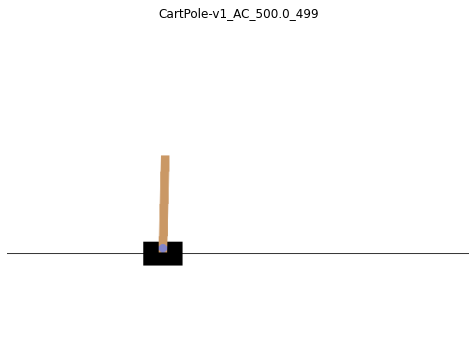

In [8]:
train(cfg)